# Random Forest Model
In this notebook, we explore how to construct and optimize random forest model. We also compare the performance of the random forest model with those of linear regression and decission tree models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


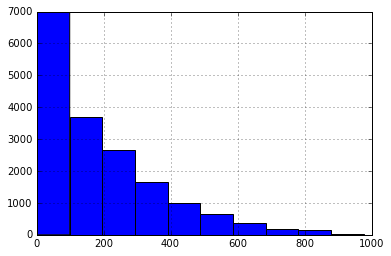

In [3]:
bike_rentals['cnt'].hist()

In [4]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Most of our features are numeric, only 1 feature (dteday) is in object form. Our data does not have any missing values.

### Univariate Analysis

In [5]:
bike_rentals.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

### Feature Engineering

the hr column contains hours ranging ffrom 1 to 24. Since there are differences in total bik rentals with different hour range, we should transform this feature to reflect it. For example, from 6am-12pm the total rental bikes will be different from that from 18pm - 24am. Let's divide a day into four time period with each period contain 6 hours of a day. 

In [6]:
def assign_label(number):
    if number in range(6,13):
        number = 1
    elif number in range(13,19):
        number = 2
    elif number in range(19,25):
        number = 3
    else: 
        number = 4
    return number

bike_rentals['time_label'] = bike_rentals['hr'].apply(lambda x: assign_label(x))
        

### Error Metrics

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well. The higher the mse score, the worse the model performs

In [44]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(bike_rentals, test_size = 0.2)
print('shape of train dataset:',train.shape,'\n','shape of test dataset:' ,test.shape)




shape of train dataset: (13903, 18) 
 shape of test dataset: (3476, 18)


### Linear Regression
Given that many of the features are highly correlated with our target feature (cnt), linear regression will work well on this dataset. However, since cnt is derived from casual and registered, we need to get rid of these features. Moreover, dteday is not a numeric feature, we should also eliminate that feature from our dataset.

In [58]:
### eliminating the aforementioned features from our concerned features
predictor_columns = [x for x in bike_rentals.columns if x not in ['cnt','casual','dteday','registered']]
print(predictor_columns)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


In [59]:
###
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
clf = LinearRegression()
clf.fit(train[predictor_columns], train['cnt'])
predictions = clf.predict(test[predictor_columns])
mse = mean_squared_error(test['cnt'], predictions)

print(mse)

16156.652923997364


The error is pretty high. This maybe because in our target feature data, we have some extreme outliers

### Decision Tree

#### GridSearchCV
DecisionTree is prone to overfitting. Two ways to improve a DecisionTree model is to optimize the max_depth and mmin_samples_leaf parameters. One way to optimize a decision tree model is using cross validation. Sklearn provides GridSearchCV that automatically performs cross validation on our data then returns the best model.

In [60]:
### import GridSearchCV and DecisionTreeRegressor from sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

### Optimize the DecisionTree on max_depth and min_samples_leaf
param_grid = {'max_depth': np.arange(1,10), 'min_samples_leaf':np.arange(1,30)}
clf = GridSearchCV(DecisionTreeRegressor(), param_grid,n_jobs =-1)
clf.fit(train[predictor_columns], train['cnt'])


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [61]:
### Calculating mean_squared_error and root mean_squared_error on the test set
prediction = clf.predict(test[predictor_columns])
mse = mean_squared_error(test['cnt'],prediction)


### print out the parameters of the best model
print('DecisionTree: root mean squared error = {}'.format(mse))
print( 'The best parameters are:', clf.best_params_)

DecisionTree: root mean squared error = 4545.941416612333
The best parameters are: {'max_depth': 9, 'min_samples_leaf': 5}


The mse of the DecisionTreeRegression significantly improves from that of the LinearRegression model from approximately 16000 down to about 5000. That's a little less than 1/3 of the original error.

### Random Forest
Random Forest is an ensemble of DecisionTree. That is the model trains several DecisionTrees then return the result either based on a majority votes or take the mean of the error from those DecisionTrees. As such, Random Forest is less prone to overfitting and usually performs better than DecisionTree. 

In [62]:
### Perform GridSearchCV using a RandomForest model, optimizing on max_depth 
### and min_samples_leaf parameters
from sklearn.ensemble import RandomForestRegressor

### In this RandomForest model, 10 DecisionTrees are trained on then their average
### error was returned
param_grid = {'max_depth': np.arange(1,10), 'min_samples_leaf':np.arange(1,30)}
reg = GridSearchCV(RandomForestRegressor(), param_grid,n_jobs =-1)
reg.fit(train[predictor_columns], train['cnt'])


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [63]:
### Calculating mean_squared_error and root mean_squared_error on the test set
prediction = reg.predict(test[predictor_columns])
mse = mean_squared_error(test['cnt'],prediction)


### print out the parameters of the best model
print('DecisionTree: root mean squared error = {}'.format(mse))
print( 'The best parameters are:', reg.best_params_)

DecisionTree: root mean squared error = 3450.25942038062
The best parameters are: {'max_depth': 9, 'min_samples_leaf': 7}


The RandomForest model performs best out of the three models as it returns an error score of about 3450. 